In [49]:
import os
import json
import numpy as np
import pandas as pd
from monty.json import MSONable
from monty.serialization import loadfn, dumpfn
from scipy.stats import skew
from glob import glob
from datetime import datetime
from beep_ep import structure_data, run_model, generate_features, run_model
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV, ElasticNetCV, ElasticNet, MultiTaskElasticNetCV, MultiTaskElasticNet

In [51]:
#Turn on/off structuring and featurizing
to_structure = 0
to_featurize = 0

raw_csvs_path = "/Users/chirranjeevigopal/Documents/d3batt_training_data/csv_files"
processed_json_path = "/Users/chirranjeevigopal/Documents/d3batt_training_data/csv_files/processed_jsons"
featurized_jsons_path = "/Users/chirranjeevigopal/Documents/d3batt_training_data/csv_files/featurized_jsons"

single_task_features_path = os.path.join(featurized_jsons_path,"single")
multi_task_features_path = os.path.join(featurized_jsons_path,"multi")
multi_task_features_path_2 = os.path.join(featurized_jsons_path,"multi_2")

if not os.path.exists(single_task_features_path):
    os.makedirs(single_task_features_path)
if not os.path.exists(multi_task_features_path):
    os.makedirs(multi_task_features_path)
if not os.path.exists(multi_task_features_path_2):
    os.makedirs(multi_task_features_path_2)

In [52]:
#Convert raw -> structured cycler runs
if(to_structure):
    all_csvs = glob(os.path.join(raw_csvs_path, "*.csv"))
    metadata_csvs = glob(os.path.join(raw_csvs_path, "*Metadata.csv"))
    cycler_csvs = list(set(all_csvs) - set(metadata_csvs))
    
    batches = ["2017-05-12", "2017-06-30", "2018-04-12"]

    for batch in batches[2:3]:
        batch_of_files = [s for s in cycler_csvs if batch in s]
       # print(batch_of_files)
        json_obj = {"file_list": batch_of_files,
                    "mode":"events_off",
                    "run_list": np.arange(len(batch_of_files)).tolist(),
                    "validity":['valid']*len(batch_of_files)}
        json_string = json.dumps(json_obj)
        json_output = structure_data.process_file_list_from_json(json_string, processed_dir=processed_json_path)

In [53]:
#find files that were continued and merge their summary dataframes. 
#Original batch 1 files are appended with an "old.json" tag
unmerged = 0
files_continued = {"batches":["2017-05-12","2017-06-30"],
                  "channels":[['CH1_','CH2_','CH3_','CH5_','CH6_'],
                             ['CH8','CH9','CH10','CH16','CH17']]}

processed_jsons = glob(os.path.join(processed_json_path, "*structure.json"))
if(unmerged):
    for i in range(5):
        file1=[s for s in processed_jsons if files_continued['batches'][0] in s and files_continued['channels'][0][i] in s]
        file2=[s for s in processed_jsons if files_continued['batches'][1] in s and files_continued['channels'][1][i] in s]
        print(i,file1,file2)

        processed1=loadfn(file1[0])
        dumpfn(processed1, file1[0].replace(".json","_old.json"))

        processed2=loadfn(file2[0])
        processed1.summary=processed1.summary[:-1].append(processed2.summary[1:],ignore_index=True)
        dumpfn(processed1, file1[0])

In [54]:
#create descriptors. prediction_type="multi" ensures that a list of cycle_lives are generated.

if(to_featurize):
    processed_jsons = glob(os.path.join(processed_json_path, "*structure.json"))
    json_obj = {"file_list": processed_jsons,
                "mode":"events_off", 
                "run_list":np.arange(len(processed_jsons)).tolist()}
    json_string = json.dumps(json_obj)
    json_output = generate_features.process_file_list_from_json(json_string, predict_only=False,
                                                                prediction_type = 'multi', processed_dir=multi_task_features_path_2)
    #json_output = generate_features.process_file_list_from_json(json_string, predict_only=False, processed_dir=multi_task_features_path)

Obtain 'bad' file list from 
https://github.com/rdbraatz/data-driven-prediction-of-battery-cycle-life-before-capacity-degradation/blob/master/Load%20Data.ipynb

In [55]:
discards= {"batches": ["2017-05-12", "2017-06-30", "2018-04-12"],
"channels": [["CH9_","CH11","CH13","CH14","CH23","CH19","CH22","CH21","CH31"],
             ["CH8_","CH9_" ,"CH10_","CH16","CH17"],
             ["CH3_","CH24","CH33","CH38","CH39","CH40","CH41"]]}

In [56]:
#Obtain list of all featurized jsons. This will be assembled for model fitting.
featurized_jsons = glob(os.path.join(multi_task_features_path, "*"))
json_obj = {"file_list": featurized_jsons,
           "mode":"events_off",
           "run_list": np.arange(len(featurized_jsons)).tolist()}
json_string = json.dumps(json_obj)

#Obtain list of all featurized jsons. This will be assembled for model fitting.
featurized_jsons_2 = glob(os.path.join(multi_task_features_path_2, "*"))
json_obj_2 = {"file_list": featurized_jsons_2,
           "mode":"events_off",
           "run_list": np.arange(len(featurized_jsons_2)).tolist()}
json_string_2 = json.dumps(json_obj_2)


In [121]:
y_actual_2.head(7)

,capacity_0.98,capacity_0.95,capacity_0.92,capacity_0.89,capacity_0.86,capacity_0.83,capacity_0.8
0,430,612,761,879,955,984,984
0,815,815,815,815,815,815,815
0,461,646,708,756,799,841,862
0,102,165,218,250,304,331,348
0,1644,1644,1644,1644,1644,1644,1644
0,324,415,456,483,504,523,541
0,397,556,613,648,681,714,733


In [57]:
#Initialize hyperparameters and train model
hyperparameters = {'random_state': 1,
                           'test_size': .3,
                           'k_fold': 5,
                           'tol': 0.001,
                           'l1_ratio': [.5, .7, .9, .95, 1],
                   'max_iter': 100000
                  }
multi_task_model = run_model.DegradationModel.train(json_string,hyperparameters=hyperparameters,model_name='d3batt_multipoint')

/Users/chirranjeevigopal/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [58]:
#Initialize hyperparameters and train model
hyperparameters = {'random_state': 1,
                           'test_size': .3,
                           'k_fold': 5,
                           'tol': 0.001,
                           'l1_ratio': [.5, .7, .9, .95, 1],
                   'max_iter': 100000
                  }
multi_task_model_2 = run_model.DegradationModel.train(json_string_2,hyperparameters=hyperparameters,model_name='d3batt_multipoint')

/Users/chirranjeevigopal/anaconda3/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [124]:
#multi_task_model.model

In [92]:
multi_task_model_2.model

{'model_type': 'linear',
 'model': {'l1_ratio': 0.9,
  'alpha': 2.039009845904885,
  'fit_intercept': True,
  'normalize': False,
  'max_iter': 100000,
  'copy_X': True,
  'tol': 0.0001,
  'warm_start': False,
  'random_state': None,
  'selection': 'cyclic',
  'coef_': array([[ 25.099, -62.816, -13.65 ,  29.232, -58.863, -37.398, -70.087,
          -46.601,  34.376,   6.096, -53.268, -32.649, 107.374,   7.209,
          -22.321, -21.938,   1.388, -21.94 , -32.105, -11.39 ],
         [ 33.824, -66.408,  -1.674,  30.402,  -3.347, -37.921, -69.688,
          -51.018,  44.162,  13.879, -62.25 , -34.488,  88.505,  16.969,
          -13.197, -25.981,  24.826, -19.471, -26.344, -27.774],
         [ 31.207, -61.601,   4.738,  21.465,  32.158, -57.284, -73.164,
          -64.686,  45.881,  28.059, -64.347, -30.693,  64.517,  -5.465,
            8.493, -17.715,  26.127, -20.585, -27.876, -41.068],
         [ 31.642, -61.442,   6.791,  19.746,  45.267, -55.829, -70.001,
          -61.746,  48.496

In [131]:
print('Rsq =', multi_task_model_2.model['Rsquare'])
print('95 % CI = ',multi_task_model_2.model['confidence_bounds']*100)
print('Cycles to reach capacities: ', np.arange(.98,.78,-.03), 'Ah')

Rsq = 0.8494525604912887
95 % CI =  [10.787 12.609 12.864 13.032  7.67   6.385  6.939]
Cycles to reach capacities:  [0.98 0.95 0.92 0.89 0.86 0.83 0.8 ] Ah


In [71]:
#Compare actual and predicted cycle times for different discharge capacities
y_actual = pd.DataFrame()
y_pred = pd.DataFrame()
featurized_jsons = glob(os.path.join(multi_task_features_path, "*"))
for f in featurized_jsons:
    feature_dict = loadfn(f)
    y_actual = y_actual.append(pd.DataFrame.from_dict(feature_dict.y))  
    y_pred =y_pred.append(multi_task_model.predict(feature_dict).tolist())

In [106]:
#Compare actual and predicted cycle times for different discharge capacities
y_actual_2 = pd.DataFrame()
y_pred_2 = pd.DataFrame()
featurized_jsons_2 = glob(os.path.join(multi_task_features_path_2, "*"))
for f in featurized_jsons_2:
    feature_dict = loadfn(f)
    y_actual_2 = y_actual_2.append(pd.DataFrame.from_dict(feature_dict.y))  
    y_pred_2 =y_pred_2.append(multi_task_model_2.predict(feature_dict).tolist())

Text(0, 0.5, 'Density')

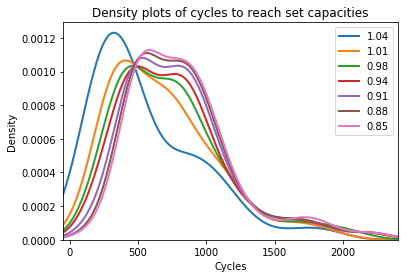

In [129]:
for i in range(y_actual_2.shape[1]):
   # plt.hist(y_actual_2.iloc[:,i],bins=50)
    sns.distplot(y_actual_2.iloc[:,i], hist = False, kde = True,
                 kde_kws = {'linewidth': 2},
                 label = np.around(1.06*(0.98-i*0.03),2))
plt.xlabel('Cycles')
plt.xlim([-50,2400])
plt.title("Density plots of cycles to reach set capacities")
plt.ylabel('Density')

/Users/chirranjeevigopal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


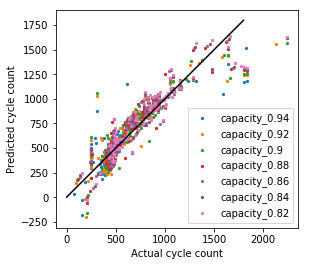

In [83]:
#Show plot of actual vs pred
cycle_min=200
cycle_max=1800
cycle_interval = 200
for i in range(y_actual.shape[1]):
    plt.scatter(y_actual.ix[:,i], y_pred.ix[:,i], s=5, marker='o')
    
plt.xlabel('Actual cycle count')
plt.legend(y_actual.columns)
plt.ylabel('Predicted cycle count')
plt.plot([0,1800], [0,1800],'k-')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

/Users/chirranjeevigopal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


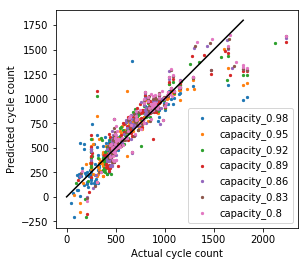

In [84]:
#Show plot of actual vs pred
cycle_min=200
cycle_max=1800
cycle_interval = 200

for i in range(y_actual_2.shape[1]):
    plt.scatter(y_actual_2.ix[:,i], y_pred_2.ix[:,i], s=5, marker='o')
    
plt.xlabel('Actual cycle count')
plt.legend(y_actual_2.columns)
plt.ylabel('Predicted cycle count')
plt.plot([0,1800], [0,1800],'k-')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [37]:
#Serialize model, and then reload serialized model
multi_task_model_2.serialize(processed_dir="../beep_ep/tests/test_files/")

In [85]:
#Plot sample discharge curves for 6 cells
processed_jsons = glob(os.path.join(processed_json_path, "*structure.json"))
processed_cycler_runs=[]
capacity_list = []
batch_of_files = [s for s in processed_jsons if "2017-06-30" in s or "2017-05-12" in s]
y_pred = pd.DataFrame()
for file in batch_of_files[0:11]:
    processed_cycler_runs.append(loadfn(file))
    max_capacity = np.median(processed_cycler_runs[-1].summary.discharge_capacity.iloc[0:40])
    capacity_list.append(np.arange(0.94,0.8,-.02)*max_capacity)
    feature_file = os.path.join(multi_task_features_path,file.split('/')[-1].replace('structure','full_model_features'))
    feature_dict = loadfn(feature_file)
   # y_actual = y_actual.append(pd.DataFrame.from_dict(feature_dict.y))  
    y_pred =y_pred.append(multi_task_model.predict(feature_dict).tolist())
#print(y_pred)

In [122]:
#Plot sample discharge curves for 6 cells
processed_jsons = glob(os.path.join(processed_json_path, "*structure.json"))
processed_cycler_runs=[]
capacity_list_2 = []
batch_of_files = [s for s in processed_jsons if "2017-06-30" in s or "2017-05-12" in s]
y_pred_2 = pd.DataFrame()
for file in batch_of_files[0:12]:
    processed_cycler_runs.append(loadfn(file))
    max_capacity = np.median(processed_cycler_runs[-1].summary.discharge_capacity.iloc[0:40])
    capacity_list_2.append(np.arange(0.98,0.78,-.03)*max_capacity)
    feature_file = os.path.join(multi_task_features_path_2,file.split('/')[-1].replace('structure','full_model_features'))
    feature_dict = loadfn(feature_file)
   # y_actual = y_actual.append(pd.DataFrame.from_dict(feature_dict.y))  
    y_pred_2 =y_pred_2.append(multi_task_model_2.predict(feature_dict).tolist())
#print(y_pred_2)

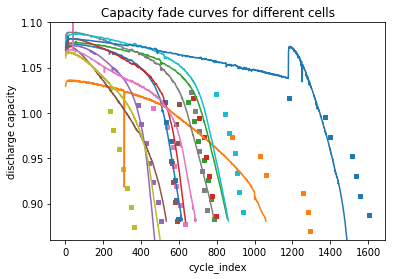

In [87]:
rows = y_pred.notna().any(axis=1)
#y_pred=y_pred[rows]
#capacity_list = capacity_list[rows.tolist()]
#processed_cycler_runs = processed_cycler_run[rows.tolist()]
for i in range(len(processed_cycler_runs)):
    if(rows.tolist()[i]):
        plt.plot(processed_cycler_runs[i].summary.discharge_capacity[1:-1])
        plt.scatter(y_pred.iloc[i,:], capacity_list[i], s=10, marker='s')
plt.ylabel('discharge capacity')
plt.xlabel('cycle_index')
plt.title('Capacity fade curves for different cells')
plt.ylim(0.86,1.1)
plt.show()

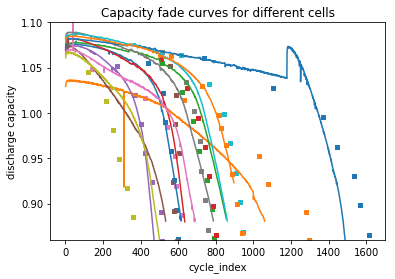

In [123]:
rows = y_pred_2.notna().any(axis=1)
#y_pred=y_pred[rows]
#capacity_list = capacity_list[rows.tolist()]
#processed_cycler_runs = processed_cycler_run[rows.tolist()]
for i in range(len(processed_cycler_runs)):
    if(rows.tolist()[i]):
        plt.plot(processed_cycler_runs[i].summary.discharge_capacity[1:-1])
        plt.scatter(y_pred_2.iloc[i,:], capacity_list_2[i], s=10, marker='s')
plt.ylabel('discharge capacity')
plt.xlabel('cycle_index')
plt.title('Capacity fade curves for different cells')
plt.ylim(0.86,1.1)
plt.show()